# Positive vs. Negative Sentiment Classification

Here we demonstrate how to explain a sentiment classification model for movie reviews. positive vs. negative sentim

In [1]:
import transformers
import datasets
import shap
import numpy as np

dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True, device=0)

Reusing dataset imdb (/home/slundberg/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


In [2]:
import shap.benchmark
import itertools
from tqdm.auto import tqdm

class SequentialMasking():
    def __init__(self, model, masker, method=["keep", "remove"], sort_order=["positive", "negative"]):
        self.runners = {}
        if isinstance(method, str):
            method = [method]
        if isinstance(sort_order, str):
            sort_order = [sort_order]
        for m,s in itertools.product(method, sort_order):
            k = m+" "+s
            self.runners[k] = shap.benchmark.perturbation.SequentialPerturbation(
                model, masker, s, m
            )

            if (m == "keep" and s == "positive") or (m == "remove" and s == "negative"):
                self.runners[k].flip = False
            elif (m == "keep" and s == "negative") or (m == "remove" and s == "positive"):
                self.runners[k].flip = True
            else:
                raise Exception(f"Need to still support the {m} {s} combination!")
    
    def __call__(self, explanation, *model_args, num_steps=100):
        out = {k: {"auc": 0, "xs": [], "ys": []} for k in self.runners}
        out["average"] = {"auc": 0, "xs": np.zeros(num_steps), "ys": np.zeros(num_steps)}
        for k in tqdm(self.runners):
            xs, ys, auc = self.runners[k].model_score(explanation, *model_args, percent=1/num_steps)
            out[k]["auc"] = auc
            out[k]["xs"] = xs
            out[k]["ys"] = ys
            out["average"]["xs"] += xs
            out["average"]["ys"] += ys * (-1 if self.runners[k].flip else 1)
            out["average"]["auc"] += auc * (-1 if self.runners[k].flip else 1)
        
        l = len(self.runners)
        out["average"]["xs"] /= l
        out["average"]["ys"] /= l
        out["average"]["auc"] /= l
        return out

In [3]:
import matplotlib.pyplot as plt
import matplotlib

def bplot(experiment):
    color_pos = 0
    color_inc = 1/len(experiment)
    for k in experiment:
        e = experiment[k]
        auc, xs, ys = experiment[k]
        c = shap.plots.colors.red_blue_circle(color_pos)
        plt.plot(np.array(e["xs"])*100, e["ys"], color=c, linewidth=2, label=f"{k} [AUC = {e['auc']:0.03g}]")
        plt.fill([0] + list(e["xs"]*100) + [e["xs"].max()*100], [0] + list(e["ys"]) + [0],color=c, alpha=0.05)
        color_pos += color_inc
    plt.ylabel("Change in model output", fontsize=13)
    plt.xlabel("Inputs affected", fontsize=13)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize=11)
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    plt.legend()#bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                #mode="expand", borderaxespad=0, ncol=3)

In [4]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=300)
scorer = SequentialMasking(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)

In [7]:
?np.random.randint

In [ ]:
new_args = masker(mask, *args)

Partition explainer: 21it [00:27,  1.32s/it]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


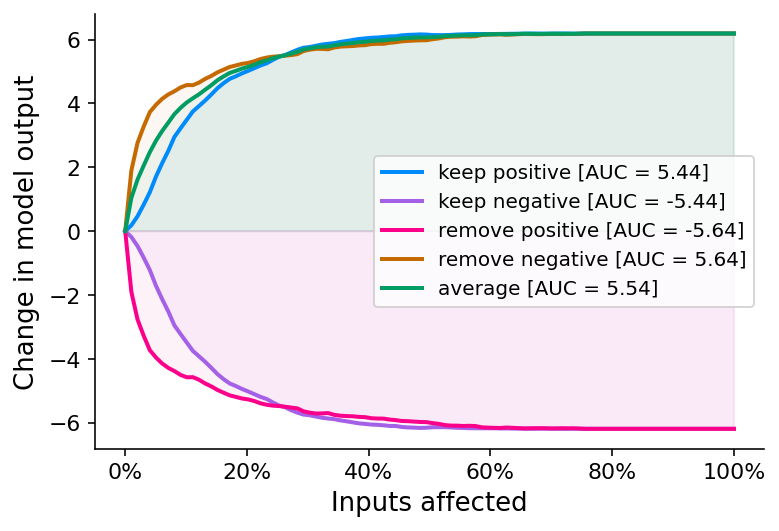

In [5]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=1200, fixed_context=1)
e2 = explainer(short_data[:50], fixed_context=1)
out2 = scorer(e2, short_data[:50])
bplot(out2)

Partition explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 3/20 [04:34<21:39, 76.46s/it]

Partition explainer:  20%|██        | 4/20 [06:18<22:36, 84.80s/it]

Partition explainer:  25%|██▌       | 5/20 [08:50<26:12, 104.83s/it]

Partition explainer:  30%|███       | 6/20 [10:23<23:40, 101.43s/it]

Partition explainer:  35%|███▌      | 7/20 [12:48<24:46, 114.33s/it]

Partition explainer:  40%|████      | 8/20 [15:19<25:06, 125.54s/it]

Partition explainer:  45%|████▌     | 9/20 [16:24<19:38, 107.17s/it]

Partition explainer:  50%|█████     | 10/20 [17:50<16:48, 100.83s/it]

Partition explainer:  55%|█████▌    | 11/20 [19:31<15:09, 101.06s/it]

Partition explainer:  60%|██████    | 12/20 [22:02<15:26, 115.85s/it]

Partition explainer:  65%|██████▌   | 13/20 [24:30<14:39, 125.67s/it]

Partition explainer:  70%|███████   | 14/20 [27:01<13:18, 133.16s/it]

Partition explainer:  75%|███████▌  | 15/20 [29:09<10:57, 131.57s/it]

Partition explainer:  80%|████████  | 16/20 [31:31<08:59, 134.87s/it]

Partition explainer:  85%|████████▌ | 17/20 [33:33<06:32, 130.75s/it]

Partition explainer:  90%|█████████ | 18/20 [35:56<04:29, 134.55s/it]

Partition explainer:  95%|█████████▌| 19/20 [38:09<02:14, 134.20s/it]

Partition explainer: 100%|██████████| 20/20 [40:45<00:00, 140.60s/it]

Partition explainer: 21it [43:04, 123.05s/it]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


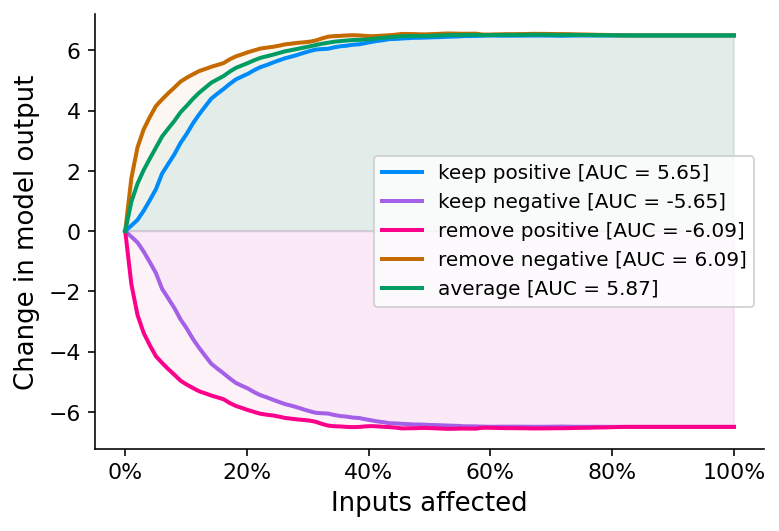

In [6]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=100000, fixed_context=1)
e2 = explainer(short_data[:50], fixed_context=1)
out2 = scorer(e2, short_data[:50])
bplot(out2)

In [1]:
import transformers
import datasets
import shap
import numpy as np

## Load the IMDB movie review dataset

In [2]:
dataset = datasets.load_dataset("imdb", split="test")

# shorten the strings to fit into the pipeline model
short_data = [v[:500] for v in dataset["text"][:20]]

Reusing dataset imdb (/home/slundberg/.cache/huggingface/datasets/imdb/plain_text/1.0.0/90099cb476936b753383ba2ae6ab2eae419b2e87f71cd5189cb9c8e5814d12a3)


## Load and run a sentiment analysis pipeline

In [3]:
classifier = transformers.pipeline('sentiment-analysis', return_all_scores=True, device=0)
classifier(short_data[:2])

[[{'label': 'NEGATIVE', 'score': 0.0012035112595185637},
  {'label': 'POSITIVE', 'score': 0.9987965226173401}],
 [{'label': 'NEGATIVE', 'score': 0.0022187831345945597},
  {'label': 'POSITIVE', 'score': 0.9977812170982361}]]

## Explain the sentiment analysis pipeline

In [4]:
# define the explainer
explainer = shap.Explainer(classifier, max_evals=500)

In [5]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:1], max_evals=500, fixed_context=1)

In [5]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:3], max_evals=500)

In [6]:
shap.plots.text(shap_values)

In [6]:
explainer3 = shap.Explainer(classifier, algorithm="permutation", max_evals=500)

In [8]:
?explainer2.__call__

In [9]:
?explainer3.__call__

In [8]:
explainer2 = shap.Explainer(classifier, algorithm="permutation", max_evals=500)
shap_values2 = explainer2(short_data[:3])

In [7]:
?explainer2

In [5]:
shap.plots.text(shap_values2[0])

In [15]:
# explain the predictions of the pipeline on the first two samples
shap_values3 = explainer(short_data[:1], max_evals=5000, fixed_context=1)

In [16]:
shap.plots.text(shap_values3[0])

In [6]:
import matplotlib.pyplot as plt
import matplotlib

def bplot(experiment):
    color_pos = 0
    color_inc = 1/len(experiment)
    for k in experiment:
        e = experiment[k]
        auc, xs, ys = experiment[k]
        c = shap.plots.colors.red_blue_circle(color_pos)
        plt.plot(np.array(e["xs"])*100, e["ys"], color=c, linewidth=2, label=f"{k} [AUC = {e['auc']:0.03g}]")
        plt.fill([0] + list(e["xs"]*100) + [e["xs"].max()*100], [0] + list(e["ys"]) + [0],color=c, alpha=0.05)
        color_pos += color_inc
    plt.ylabel("Change in model output", fontsize=13)
    plt.xlabel("Inputs affected", fontsize=13)
    ax = plt.gca()
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.tick_params(labelsize=11)
    ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
    plt.legend()#bbox_to_anchor=(0,1.02,1,0.2), loc="lower left",
                #mode="expand", borderaxespad=0, ncol=3)

In [7]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=300)
explainer2 = shap.Explainer(classifier, algorithm="permutation", max_evals=300)
scorer = SequentialMasking(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)
# e1 = explainer(short_data[:50])
# out = scorer(e1, short_data[:50])

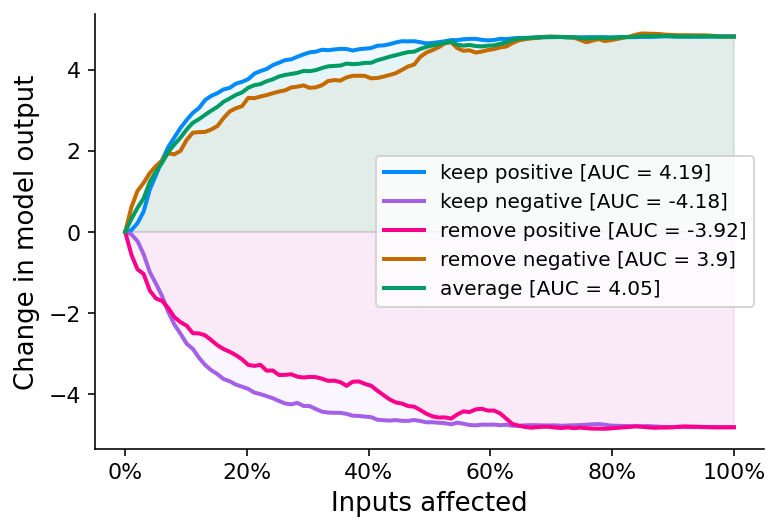

In [14]:
bplot(out)

In [12]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=600, fixed_context=0)
scorer = SequentialMasking(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)
e1 = explainer(short_data[:50], fixed_context=0)
out1 = scorer(e1, short_data[:50])

Partition explainer: 21it [00:11,  1.90it/s]                


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [9]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=600, fixed_context=1)
e2 = explainer(short_data[:50], fixed_context=1)
out2 = scorer(e2, short_data[:50])
bplot(out2)

Partition explainer: 21it [00:15,  1.38it/s]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


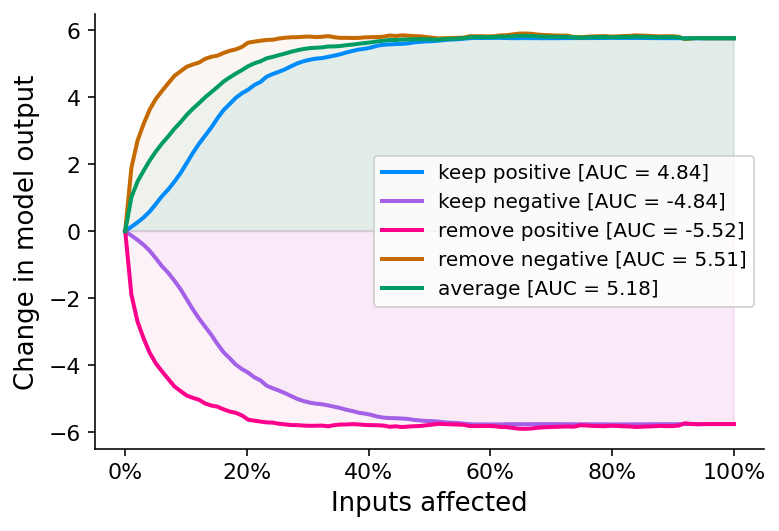

In [15]:
bplot(out2)

Partition explainer: 21it [00:30,  1.45s/it]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


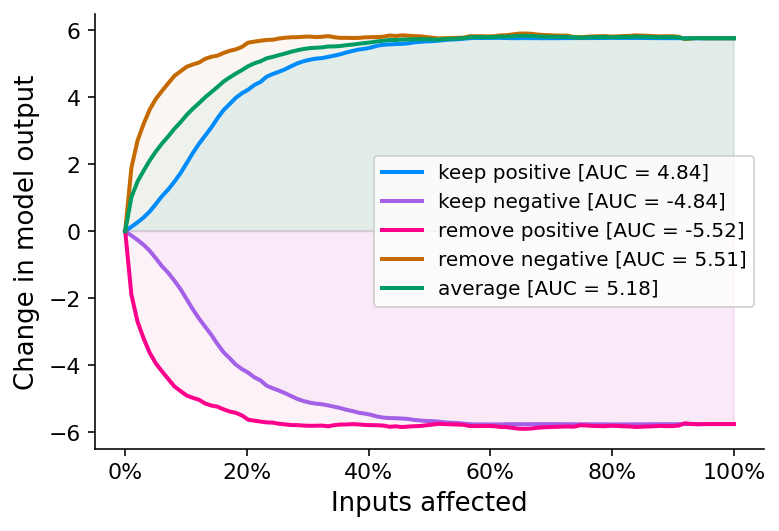

In [8]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=1200, fixed_context=1)
e2 = explainer(short_data[:50], fixed_context=1)
out2 = scorer(e2, short_data[:50])
bplot(out2)

In [ ]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=1200, fixed_context=1)
e2 = explainer(short_data[:50], fixed_context=1)
out2 = scorer(e2, short_data[:50])

Partition explainer:  80%|████████  | 16/20 [00:11<00:01,  2.53it/s]

Permutation explainer: 21it [07:40, 21.92s/it]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


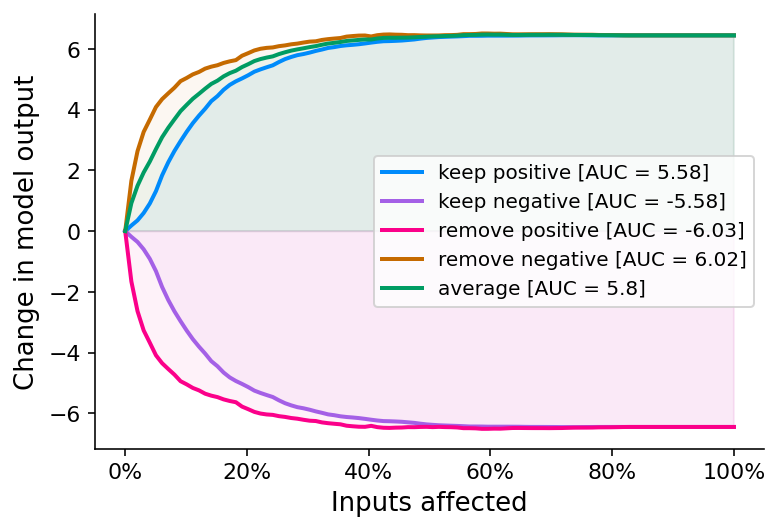

In [22]:
explainer = shap.Explainer(classifier, algorithm="permutation", max_evals=10000)
e5 = explainer(short_data[:50])
out5 = scorer(e5, short_data[:50])
bplot(out5)

Partition explainer:   5%|▌         | 1/20 [00:00<?, ?it/s]

Partition explainer:  15%|█▌        | 3/20 [00:28<02:01,  7.13s/it]

Partition explainer:  20%|██        | 4/20 [00:40<02:17,  8.59s/it]

Partition explainer:  25%|██▌       | 5/20 [00:54<02:33, 10.25s/it]

Partition explainer:  30%|███       | 6/20 [01:05<02:29, 10.70s/it]

Partition explainer:  35%|███▌      | 7/20 [01:19<02:28, 11.43s/it]

Partition explainer:  40%|████      | 8/20 [01:33<02:28, 12.35s/it]

Partition explainer:  45%|████▌     | 9/20 [01:45<02:13, 12.16s/it]

Partition explainer:  50%|█████     | 10/20 [01:57<02:00, 12.09s/it]

Partition explainer:  55%|█████▌    | 11/20 [02:10<01:51, 12.37s/it]

Partition explainer:  60%|██████    | 12/20 [02:24<01:44, 13.09s/it]

Partition explainer:  65%|██████▌   | 13/20 [02:40<01:36, 13.80s/it]

Partition explainer:  70%|███████   | 14/20 [02:55<01:25, 14.24s/it]

Partition explainer:  75%|███████▌  | 15/20 [03:10<01:11, 14.29s/it]

Partition explainer:  80%|████████  | 16/20 [03:25<00:57, 14.50s/it]

Partition explainer:  85%|████████▌ | 17/20 [03:39<00:43, 14.41s/it]

Partition explainer:  90%|█████████ | 18/20 [03:54<00:29, 14.57s/it]

Partition explainer:  95%|█████████▌| 19/20 [04:08<00:14, 14.57s/it]

Partition explainer: 100%|██████████| 20/20 [04:24<00:00, 14.89s/it]

Partition explainer: 21it [04:39, 13.33s/it]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


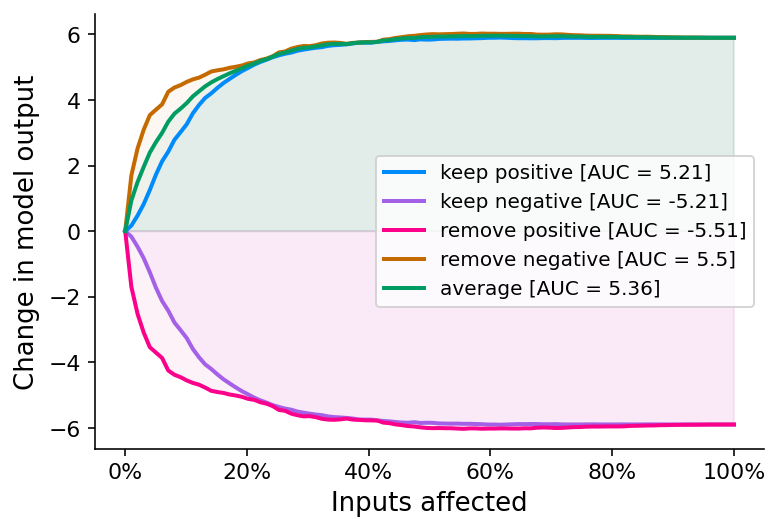

In [49]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=10000)
e5 = explainer(short_data[:50], fixed_context=None)
out5 = scorer(e5, short_data[:50])
bplot(out5)

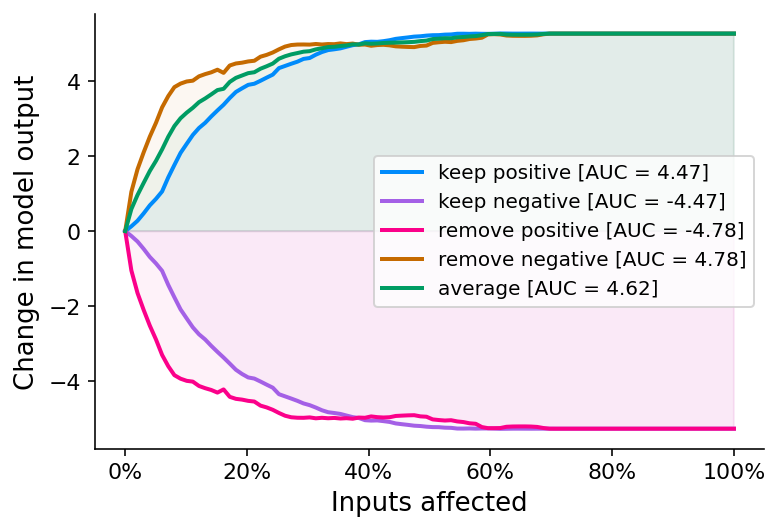

In [16]:
bplot(out5)

In [27]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=300)
e3 = explainer(short_data[:50], fixed_context=None)
out3 = scorer(e3, short_data[:50])

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Partition explainer: 21it [00:15,  1.33it/s]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


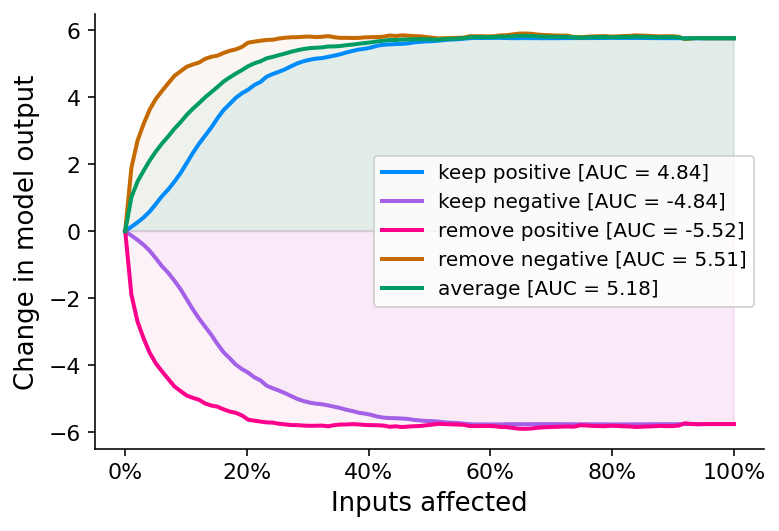

Partition explainer: 21it [00:11,  1.89it/s]                


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


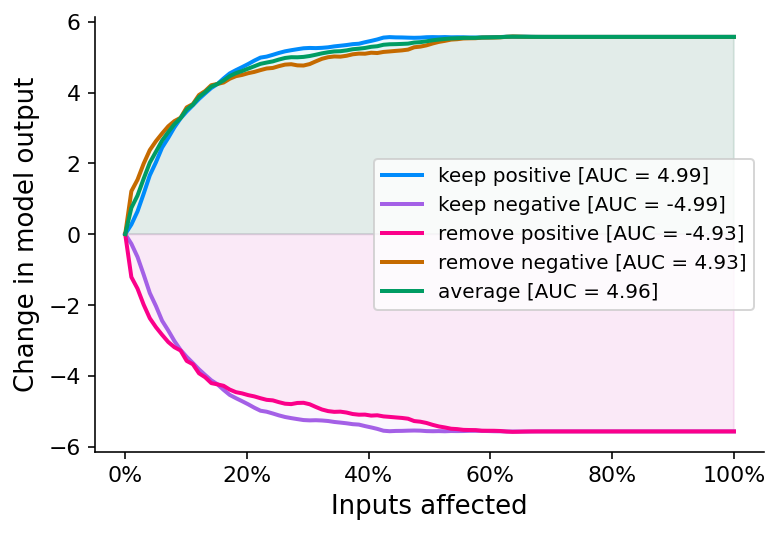

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


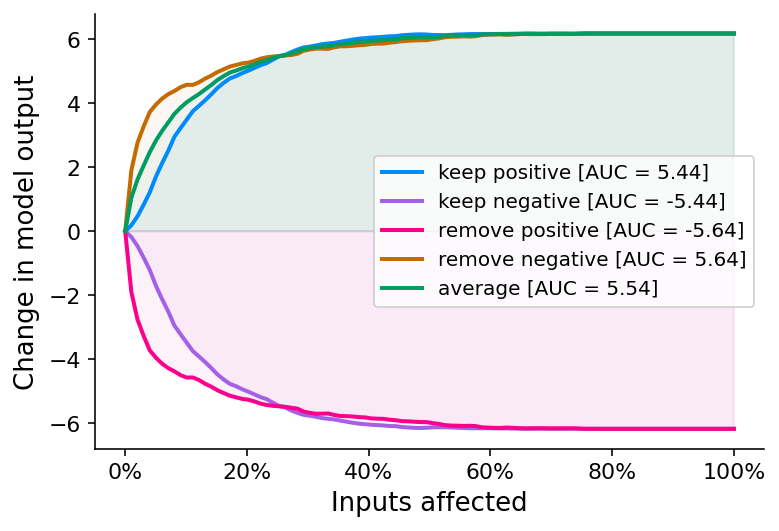

In [25]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=500)
e6 = explainer(short_data[:50], fixed_context=1)
out6 = scorer(e6, short_data[:50])
bplot(out6)
plt.show()
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=500)
e7 = explainer(short_data[:50], fixed_context=0)
out7 = scorer(e7, short_data[:50])
bplot(out7)
plt.show()
out8 = scorer(e6.values + e7.values, short_data[:50])
bplot(out8)
plt.show()

In [24]:
explainer.last_eval_count

226

In [28]:
out4 = scorer(e1.values + e2.values, short_data[:50])

In [27]:
def powerset(iterable):
    s = list(iterable)
    return itertools.chain.from_iterable(itertools.combinations(s, r) for r in range(len(s)+1))

In [47]:
mask = np.zeros(7, dtype=np.bool)
s = list(powerset([0,1,2,3,4,5,6]))
print(len(s))
count = 0
for v in s:
    count += 1
    if count > len(s)/2:
        break
    mask[:] = 0
    mask[list(v)] = 1
    print(mask.astype(np.int))
    print((~mask).astype(np.int))
    
#     mask[:] = 0
#     mask[list(v2)] = 1
#     print(mask)
#     print()

128
[0 0 0 0 0 0 0]
[1 1 1 1 1 1 1]
[1 0 0 0 0 0 0]
[0 1 1 1 1 1 1]
[0 1 0 0 0 0 0]
[1 0 1 1 1 1 1]
[0 0 1 0 0 0 0]
[1 1 0 1 1 1 1]
[0 0 0 1 0 0 0]
[1 1 1 0 1 1 1]
[0 0 0 0 1 0 0]
[1 1 1 1 0 1 1]
[0 0 0 0 0 1 0]
[1 1 1 1 1 0 1]
[0 0 0 0 0 0 1]
[1 1 1 1 1 1 0]
[1 1 0 0 0 0 0]
[0 0 1 1 1 1 1]
[1 0 1 0 0 0 0]
[0 1 0 1 1 1 1]
[1 0 0 1 0 0 0]
[0 1 1 0 1 1 1]
[1 0 0 0 1 0 0]
[0 1 1 1 0 1 1]
[1 0 0 0 0 1 0]
[0 1 1 1 1 0 1]
[1 0 0 0 0 0 1]
[0 1 1 1 1 1 0]
[0 1 1 0 0 0 0]
[1 0 0 1 1 1 1]
[0 1 0 1 0 0 0]
[1 0 1 0 1 1 1]
[0 1 0 0 1 0 0]
[1 0 1 1 0 1 1]
[0 1 0 0 0 1 0]
[1 0 1 1 1 0 1]
[0 1 0 0 0 0 1]
[1 0 1 1 1 1 0]
[0 0 1 1 0 0 0]
[1 1 0 0 1 1 1]
[0 0 1 0 1 0 0]
[1 1 0 1 0 1 1]
[0 0 1 0 0 1 0]
[1 1 0 1 1 0 1]
[0 0 1 0 0 0 1]
[1 1 0 1 1 1 0]
[0 0 0 1 1 0 0]
[1 1 1 0 0 1 1]
[0 0 0 1 0 1 0]
[1 1 1 0 1 0 1]
[0 0 0 1 0 0 1]
[1 1 1 0 1 1 0]
[0 0 0 0 1 1 0]
[1 1 1 1 0 0 1]
[0 0 0 0 1 0 1]
[1 1 1 1 0 1 0]
[0 0 0 0 0 1 1]
[1 1 1 1 1 0 0]
[1 1 1 0 0 0 0]
[0 0 0 1 1 1 1]
[1 1 0 1 0 0 0]
[0 0 1 0 1 1 1]
[1 1

In [35]:
s

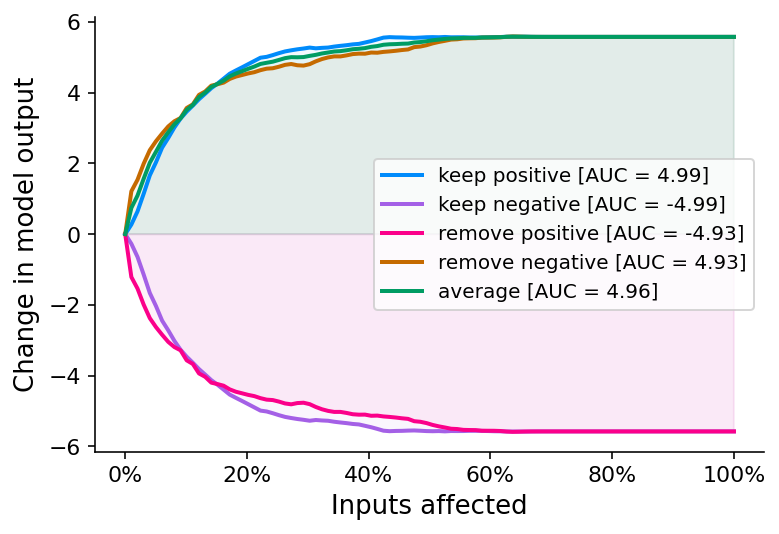

In [35]:
bplot(out1)

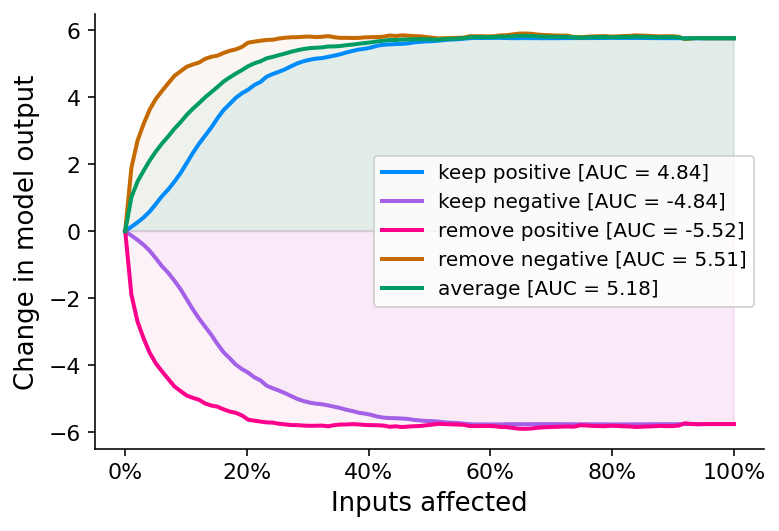

In [36]:
bplot(out2)

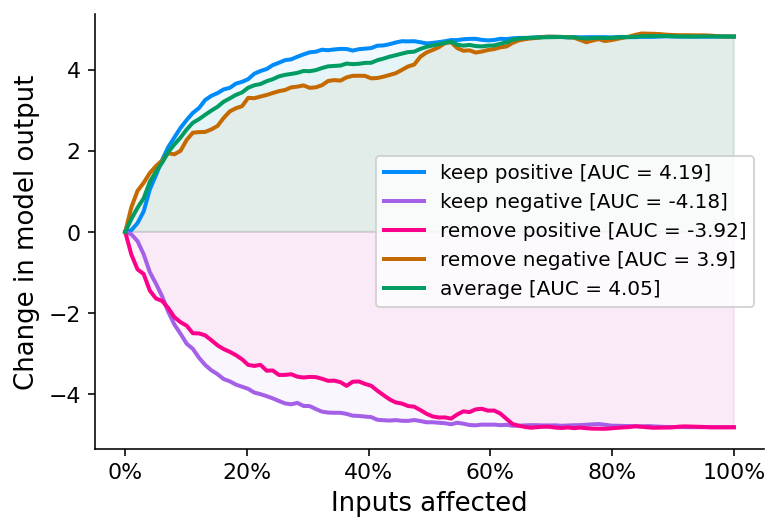

In [31]:
bplot(out3)

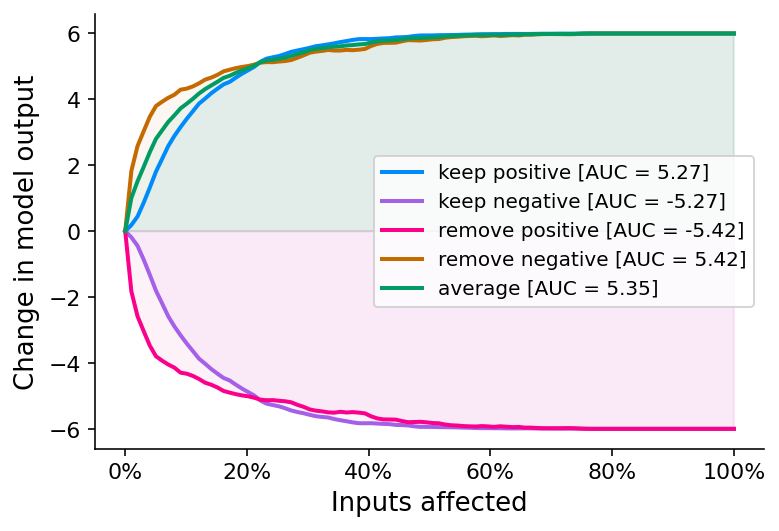

In [32]:
bplot(out4)

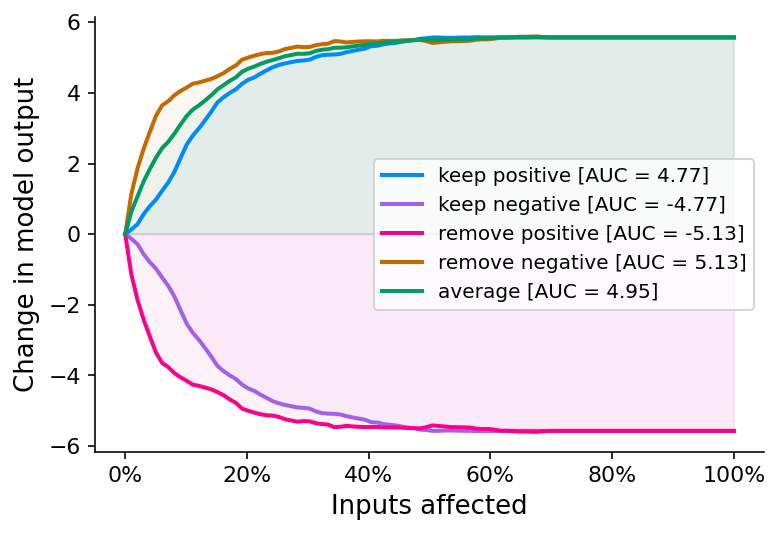

In [38]:
bplot(out5)

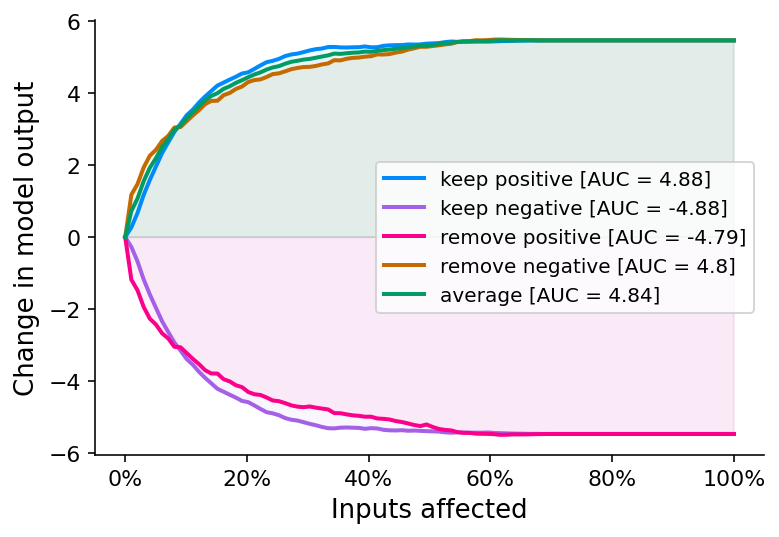

In [29]:
bplot(out1)

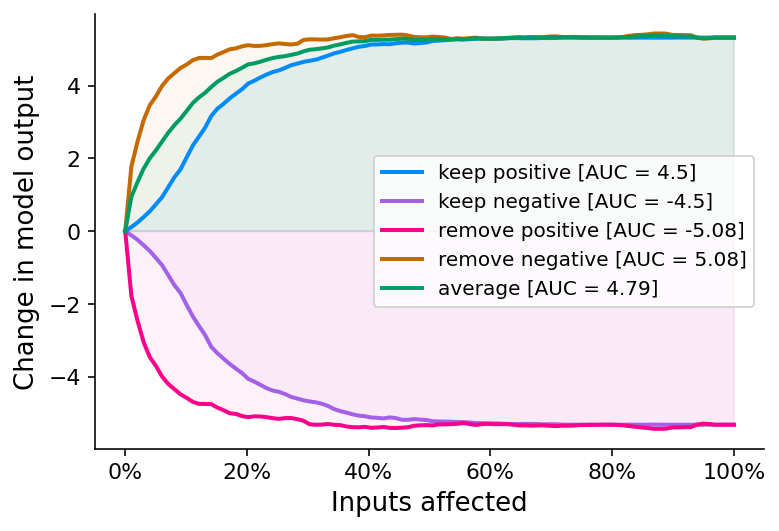

In [30]:
bplot(out2)

In [5]:
import matplotlib.pyplot as plt
import matplotlib

In [6]:
class Comparator():
    def __init__(self, explainers, scorer):
        self.explainers = explainers
        self.scorer = scorer
        
    def __call__(self, *model_args):
        explanations = [e(*model_args) for e in self.explainers]
        out = {}
        for i, explanation in enumerate(explanations):
            out[str(self.explainers[i])] = self.scorer(explanation, *model_args)
        return out
    

In [ ]:
shap.benchmark.scorers.SequentialMasking()
shap.benchmark.Comparator()

In [8]:
import functools

In [49]:
def f1(a, b=3):
    """ best!!
    """
    return a, b


f2 = functools.partial(f1, b=6)
f3 = functools.update_wrapper(f2, f1)

In [50]:
f3

functools.partial(<function f1 at 0x7f513e5779e0>, b=6)

In [51]:
f1

<function __main__.f1(a, b=3)>

In [37]:
bplot.func_defaults

AttributeError: 'function' object has no attribute 'func_defaults'

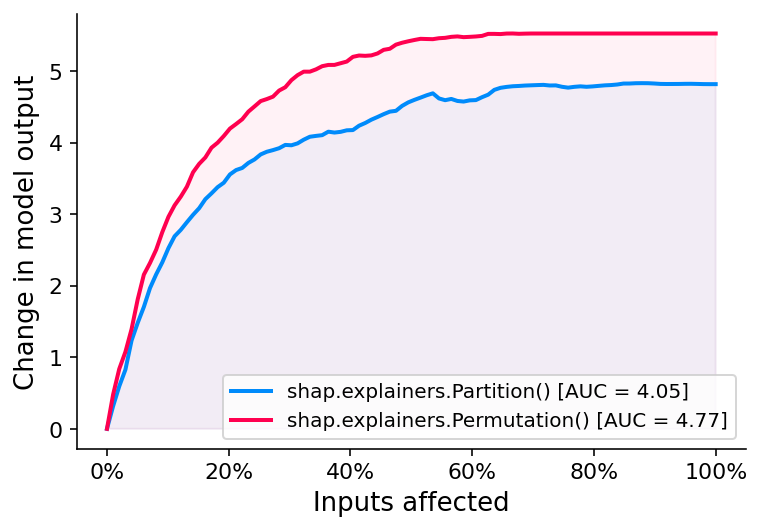

In [29]:
bplot(experiment)

In [80]:
explainer = shap.Explainer(classifier, algorithm="partition", max_evals=300)
explainer2 = shap.Explainer(classifier, algorithm="permutation", max_evals=300)
scorer = SequentialMasking(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)
out = scorer(explainer, short_data[:5])

AttributeError: 'str' object has no attribute 'model_score'

In [18]:

explainer = shap.Explainer(classifier, algorithm="partition", max_evals=300)
explainer2 = shap.Explainer(classifier, algorithm="permutation", max_evals=300)
scorer = SequentialMasking(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)
comp = Comparator([explainer, explainer2], scorer)
experiment = comp(short_data[:50])

Permutation explainer: 21it [00:13,  1.51it/s]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [32]:
a = scorer.runners[0].model_score

In [33]:
shap.benchmark.sequential_masking(
    model, masker, explainer_constructors
    explainer_constructors
    method=["keep", "remove"],
    sort_order=["positive", "negative"],
)

In [67]:
data = short_data[:10]
evals_counts = np.array([int(v) for v in np.linspace(0, 2000, 10)])
aucs = {
    "partition": [],
    "permutation": [],
}
scorer = SequentialMasking(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)
for max_evals in evals_counts:
    out1 = scorer(shap.Explainer(classifier, algorithm="partition", max_evals=max_evals)(data), data)
    aucs["partition"].append(out1[0])
    
    try:
        out2 = scorer(shap.Explainer(classifier, algorithm="permutation", max_evals=max_evals)(data), data)
        aucs["permutation"].append(out2[0])
    except:
        aucs["permutation"].append(0)
all_exp = {
    "partition": [0, evals_counts, aucs["partition"]],
    "permutation": [0, evals_counts, aucs["permutation"]]
}

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Partition explainer: 11it [00:10,  1.08it/s]                


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Partition explainer: 11it [00:11,  1.08s/it]               


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Permutation explainer: 11it [00:10,  1.00it/s]                


Partition explainer: 11it [00:13,  1.20s/it]                        


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Permutation explainer: 11it [00:11,  1.09s/it]               


In [39]:
evals_counts

[0, 150, 300]

In [40]:
aucs["partition"]

[2.095230124451543, 4.163063489428218, 4.343454192361932]

[0, 0, 22200, 44400, 66600, 88800, 111100, 133300, 155500, 177700, 200000, 2000]
[0, 0, 22200, 44400, 66600, 88800, 111100, 133300, 155500, 177700, 200000, 2000]


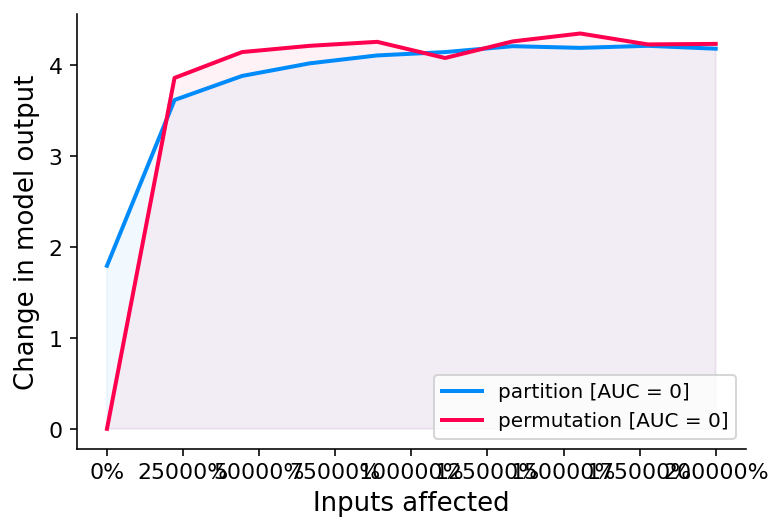

In [68]:
bplot(all_exp)

[0, 0, 55500, 111100, 166600, 222200, 277700, 333300, 388800, 444400, 500000, 5000]
[0, 0, 55500, 111100, 166600, 222200, 277700, 333300, 388800, 444400, 500000, 5000]


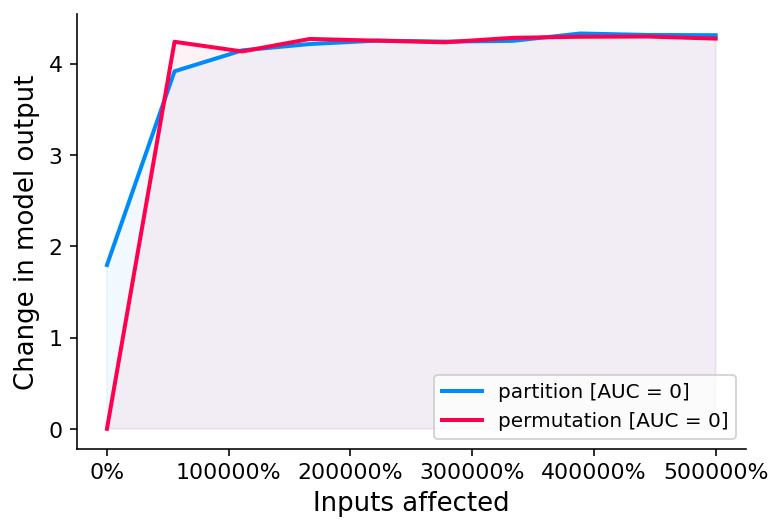

In [66]:
bplot(all_exp)

[0, 0, 5500, 11100, 16600, 22200, 27700, 33300, 38800, 44400, 50000, 500]
[0, 0, 5500, 11100, 16600, 22200, 27700, 33300, 38800, 44400, 50000, 500]


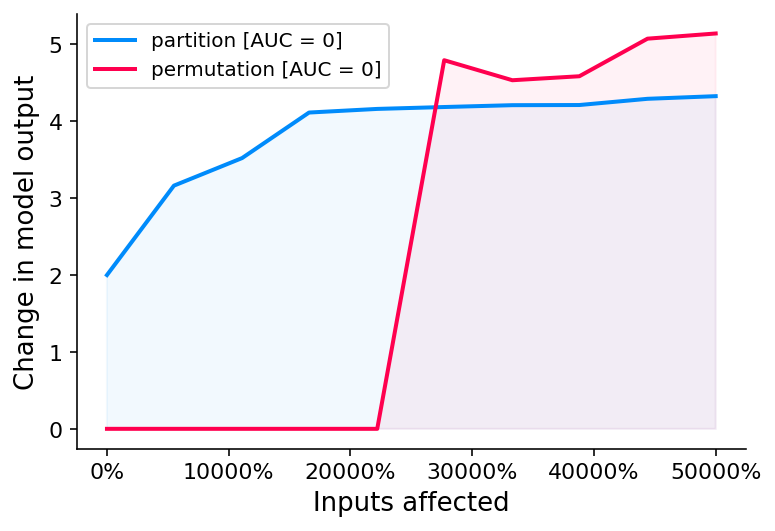

In [52]:
bplot(all_exp)

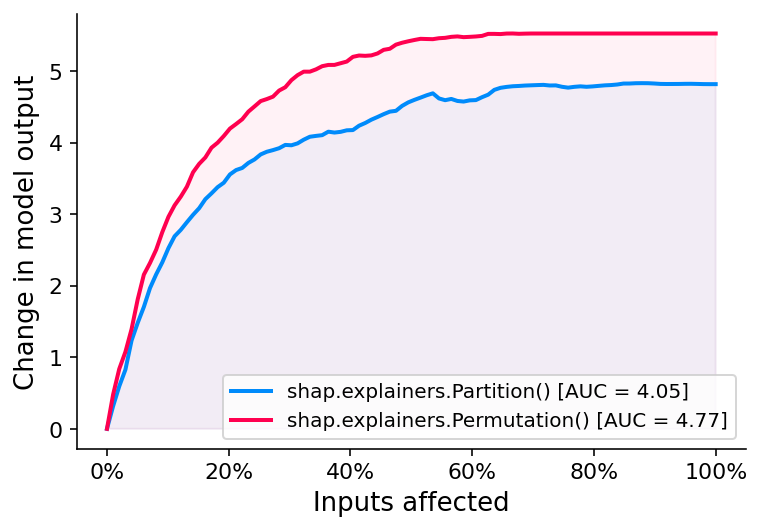

In [19]:
bplot(experiment)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


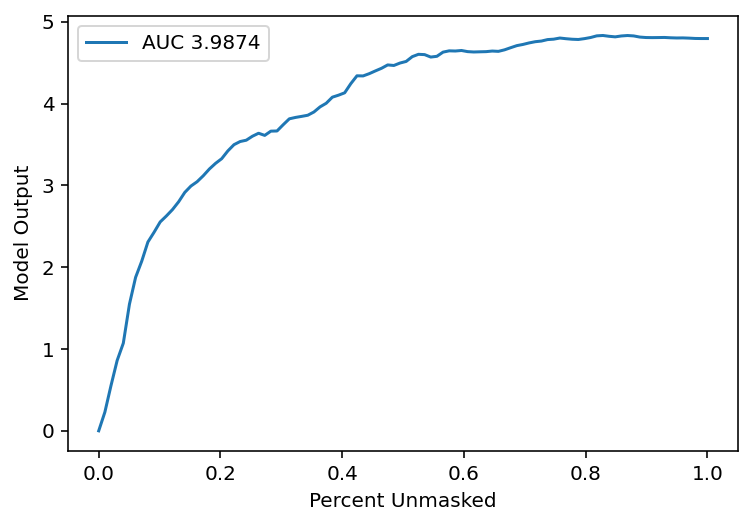

In [14]:
sequential = SequentialMasker(
    explainer.model, explainer.masker, ["keep", "remove"], ["positive", "negative"]
)
auc, xs, ys = sequential(shap_values, short_data[:10])
sequential_perturbation.plot(xs, ys, auc)

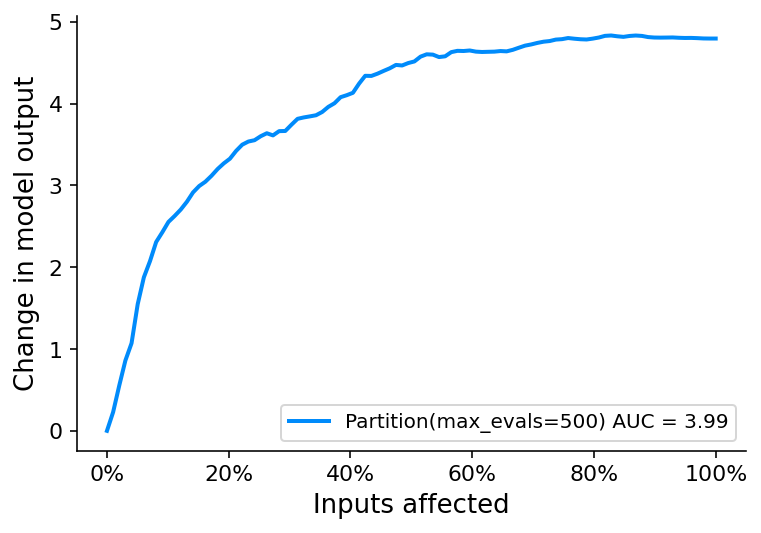

In [43]:
plt.plot(xs*100, ys, color=shap.plots.colors.blue_rgb, linewidth=2, label=f"Partition(max_evals=500) AUC = {auc:0.03g}")
plt.ylabel("Change in model output", fontsize=13)
plt.xlabel("Inputs affected", fontsize=13)
ax = plt.gca()
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(labelsize=11)
ax.xaxis.set_major_formatter(matplotlib.ticker.PercentFormatter())
plt.legend()

negative keep
- 4.682813737571954


Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


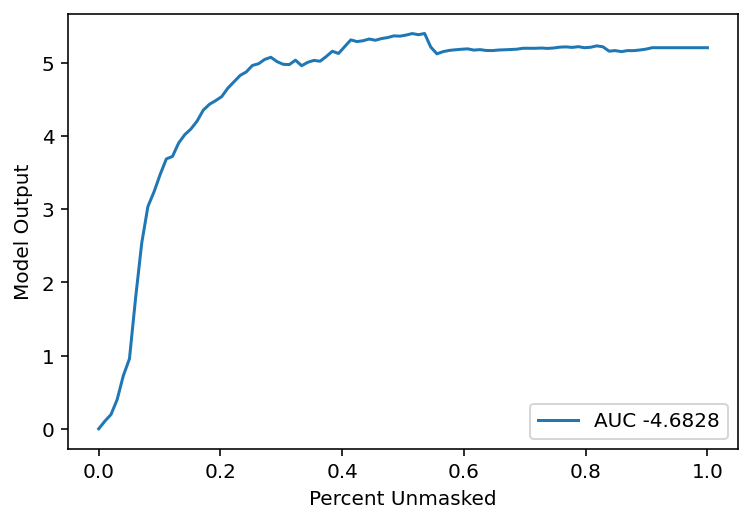

In [53]:
sequential = SequentialMasker(
    explainer.model, explainer.masker, "keep", "negative"
)
auc, xs, ys = sequential(shap_values, short_data[:3])
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


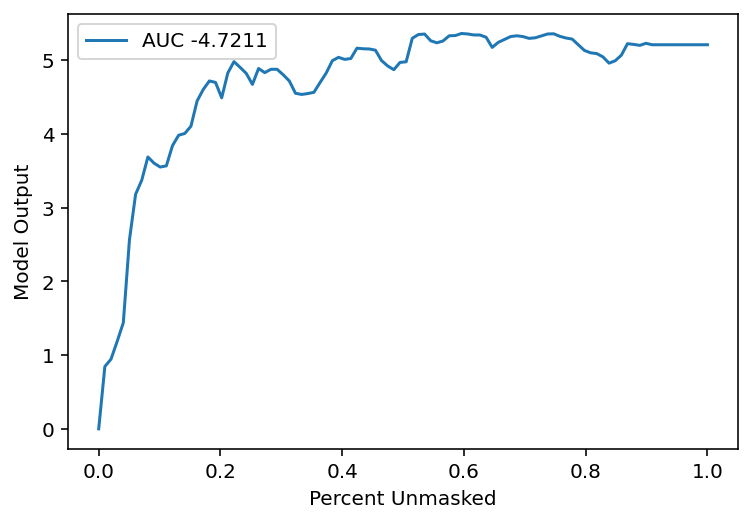

In [31]:
sequential = SequentialMasker(
    explainer.model, explainer.masker, "remove", "negative"
)
auc, xs, ys = sequential(shap_values, short_data[:3])
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


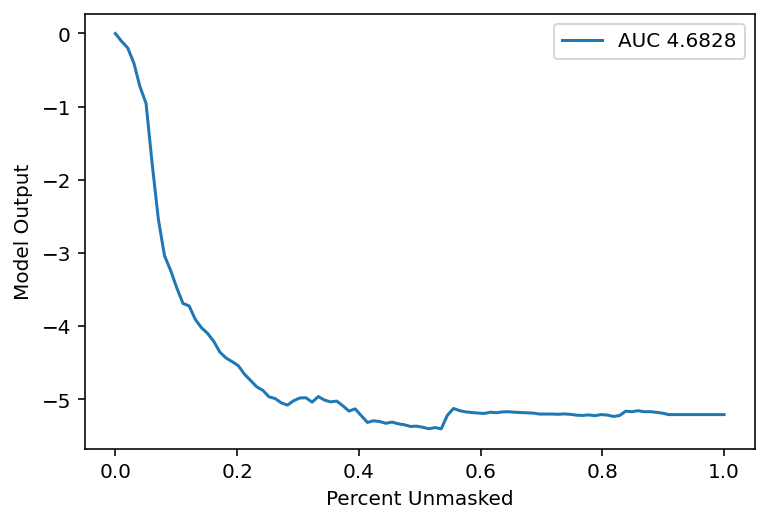

In [32]:
sequential = SequentialMasker(
    explainer.model, explainer.masker, "keep", "negative"
)
auc, xs, ys = sequential(shap_values, short_data[:3])
sequential_perturbation.plot(xs, ys, auc)

In [37]:
?sequential_perturbation.model_score

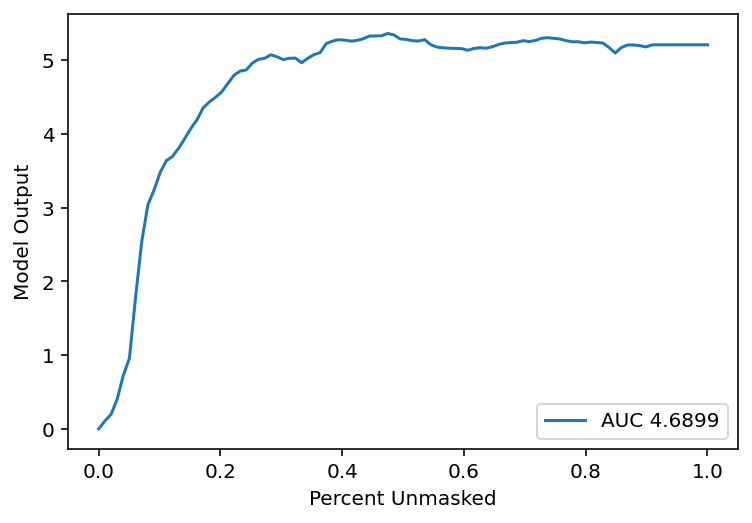

In [9]:
sequential_perturbation = shap.benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, "positive", "keep"
)
xs, ys, auc = sequential_perturbation.model_score(shap_values, short_data[:3])
sequential_perturbation.plot(xs, ys, auc)

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


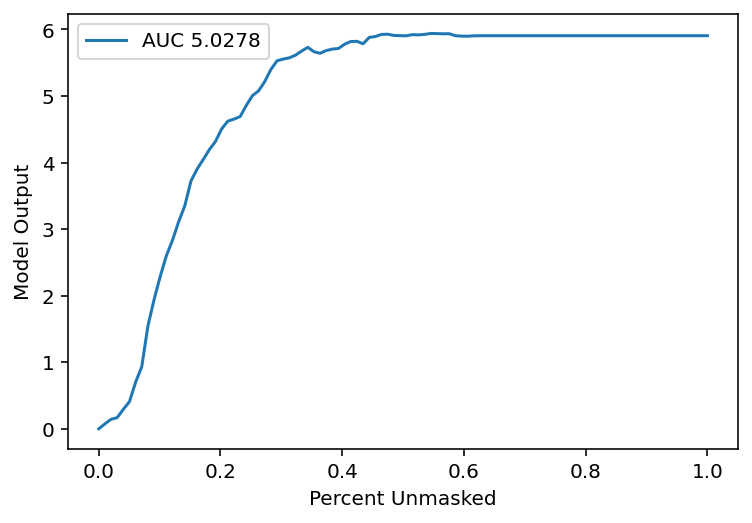

In [24]:
sequential_perturbation = shap.benchmark.perturbation.SequentialPerturbation(
    explainer.model, explainer.masker, "positive", "keep"
)
xs, ys, auc = sequential_perturbation.model_score(shap_values2, short_data[:3])
sequential_perturbation.plot(xs, ys, auc)

In [8]:
shap.plots.text(shap_values[0,:,0])

In [ ]:
def values_min_max(values, base_values):
    """ Used to pick our axis limits.
    """
    fx = base_values + values.sum()
    xmin = fx - values[values > 0].sum()
    xmax = fx - values[values < 0].sum()
    cmax = max(abs(values.min()), abs(values.max()))
    d = xmax - xmin
    xmin -= 0.1 * d
    xmax += 0.1 * d

    return xmin, xmax, cmax

In [8]:
np.ones((2, 10)).sum(-1)

array([10., 10.])

In [ ]:
shap.plots.text(shap_values[:,:,"POSITIVE"])

## Wrap the pipeline manually

SHAP requires tensor outputs from the classifier, and explanations works best in additive spaces so we transform the probabilities into logit values (information values instead of probabilites).

### Create a TransformersPipeline wrapper

In [71]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=False)

In [73]:
pmodel(short_data[:3])

array([[1.20351184e-03, 9.98796523e-01],
       [2.21878104e-03, 9.97781217e-01],
       [7.12198380e-04, 9.99287844e-01]])

In [81]:
pmodel = shap.models.TransformersPipeline(classifier, rescale_to_logits=True)
pmodel(short_data[:2])

array([[-6.72130722,  6.72133589],
       [-6.10857607,  6.10857523]])

In [13]:
explainer2 = shap.Explainer(pmodel)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

### Pass a tokenizer as the masker object

In [74]:
?shap.Explainer

In [15]:
explainer2 = shap.Explainer(pmodel, classifier.tokenizer)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

### Build a Text masker explicitly

In [35]:
masker = shap.maskers.Text(classifier.tokenizer)
explainer2 = shap.Explainer(pmodel, masker)
shap_values2 = explainer2(short_data[:2])
shap.plots.text(shap_values2[:,:,1])

## Explore how the Text masker works

In [77]:
masker.shape("I like this movie.")

(1, 7)

In [78]:
model_args = masker(np.array([True, True, True, True, True, True, True]), "I like this movie.")
model_args

(array(['i like this movie .'], dtype='<U19'),)

In [49]:
pmodel(*model_args)

array([[-8.90780458,  8.90742142]])

In [50]:
model_args = masker(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args

(array(['i [MASK] [MASK] movie .'], dtype='<U23'),)

In [51]:
pmodel(*model_args)

array([[-3.72092204,  3.72092316]])

In [79]:
model_args = masker(np.array([True, True, True, True, True, False, True]), "I like this movie.")
model_args

(array(['i like this movie [MASK]'], dtype='<U24'),)

In [82]:
pmodel(*model_args)

array([[-8.78806836,  8.7876172 ]])

In [52]:
masker2 = shap.maskers.Text(classifier.tokenizer, mask_token="...", collapse_mask_token=True)

In [83]:
model_args2 = masker2(np.array([True, True, False, False, True, True, True]), "I like this movie.")
model_args2

(array(['i . . . movie .'], dtype='<U15'),)

In [84]:
pmodel(*model_args2)

array([[-3.20818664,  3.20818753]])

## Plot summary statistics and bar charts

In [85]:
# explain the predictions of the pipeline on the first two samples
shap_values = explainer(short_data[:20])

Partition explainer: 21it [00:11,  1.81it/s]                        


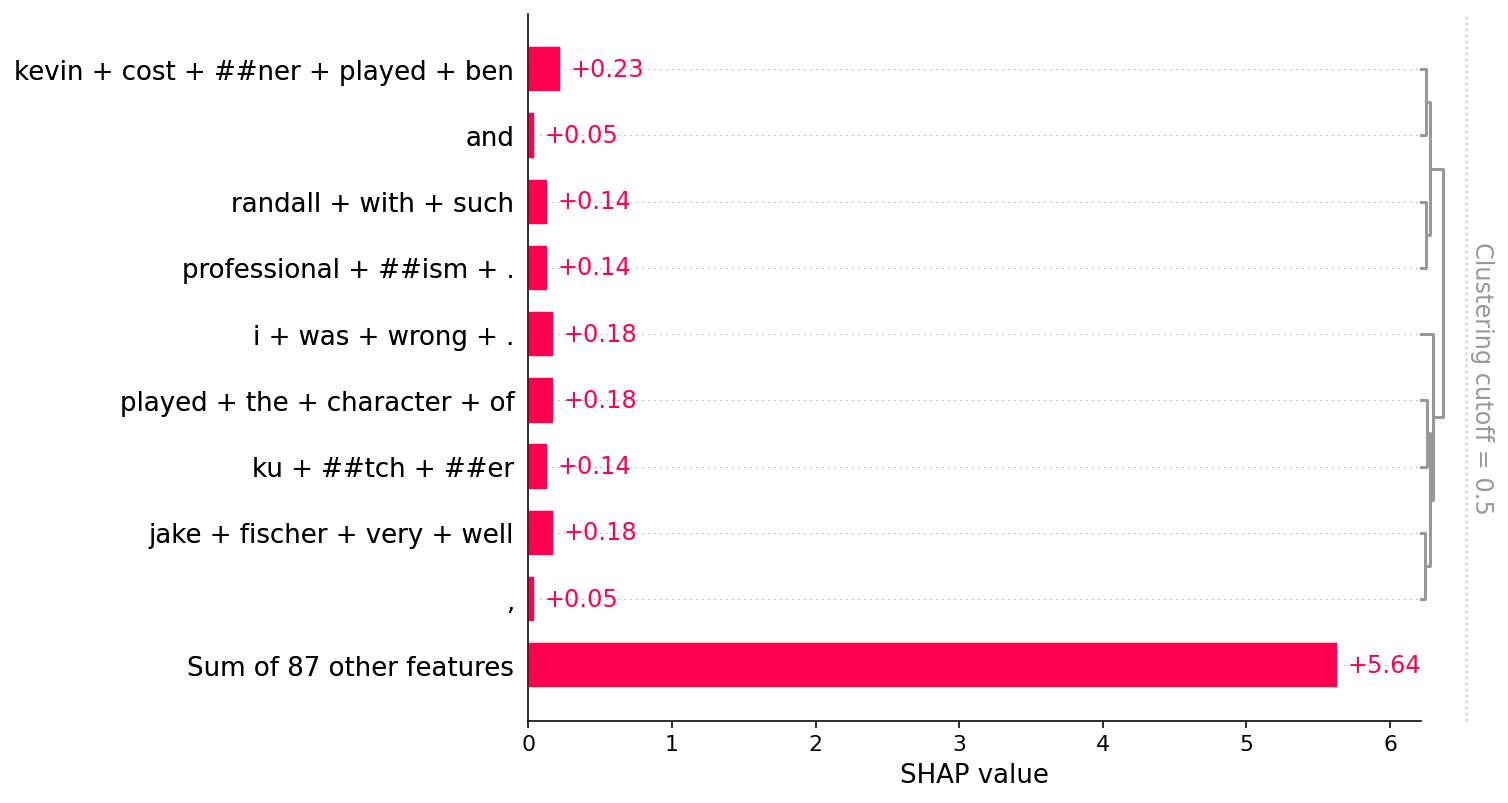

In [87]:
shap.plots.bar(shap_values[0,:,"POSITIVE"])

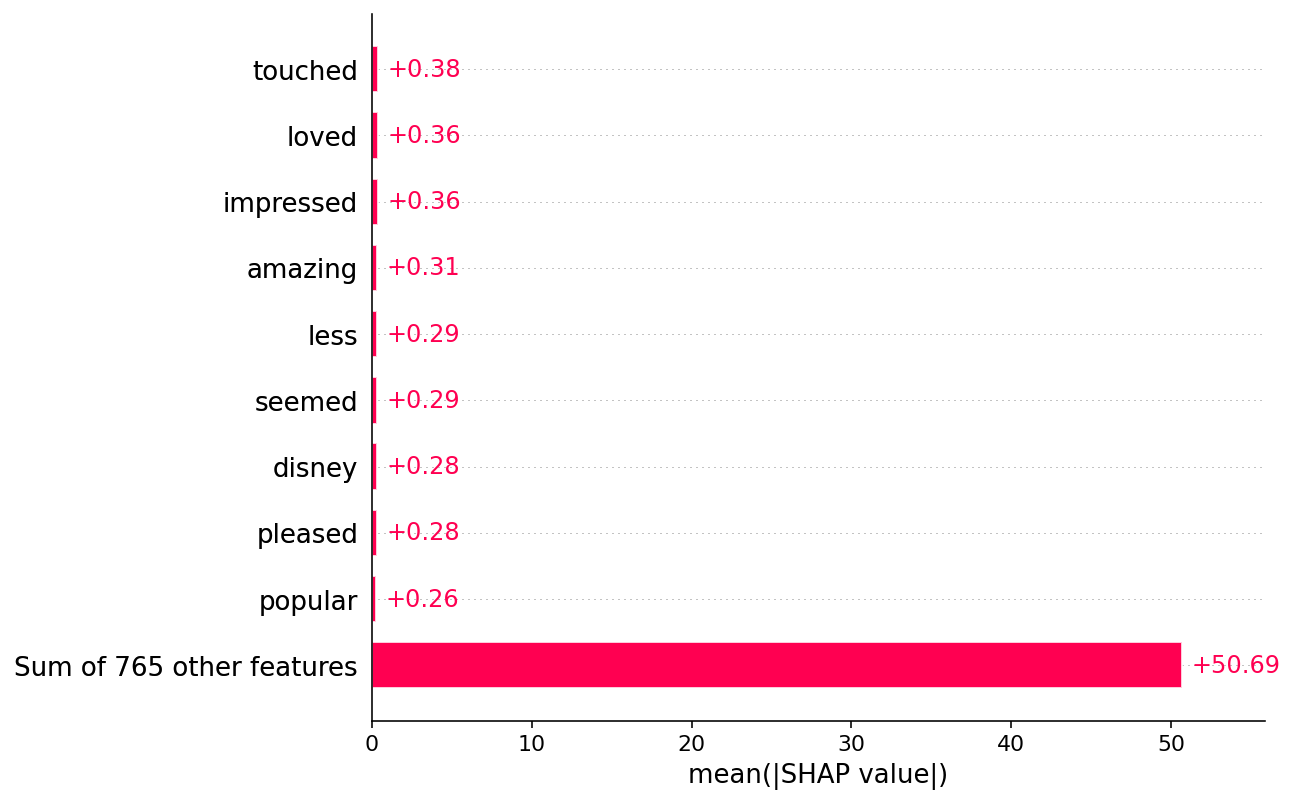

In [91]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].abs.mean(0))

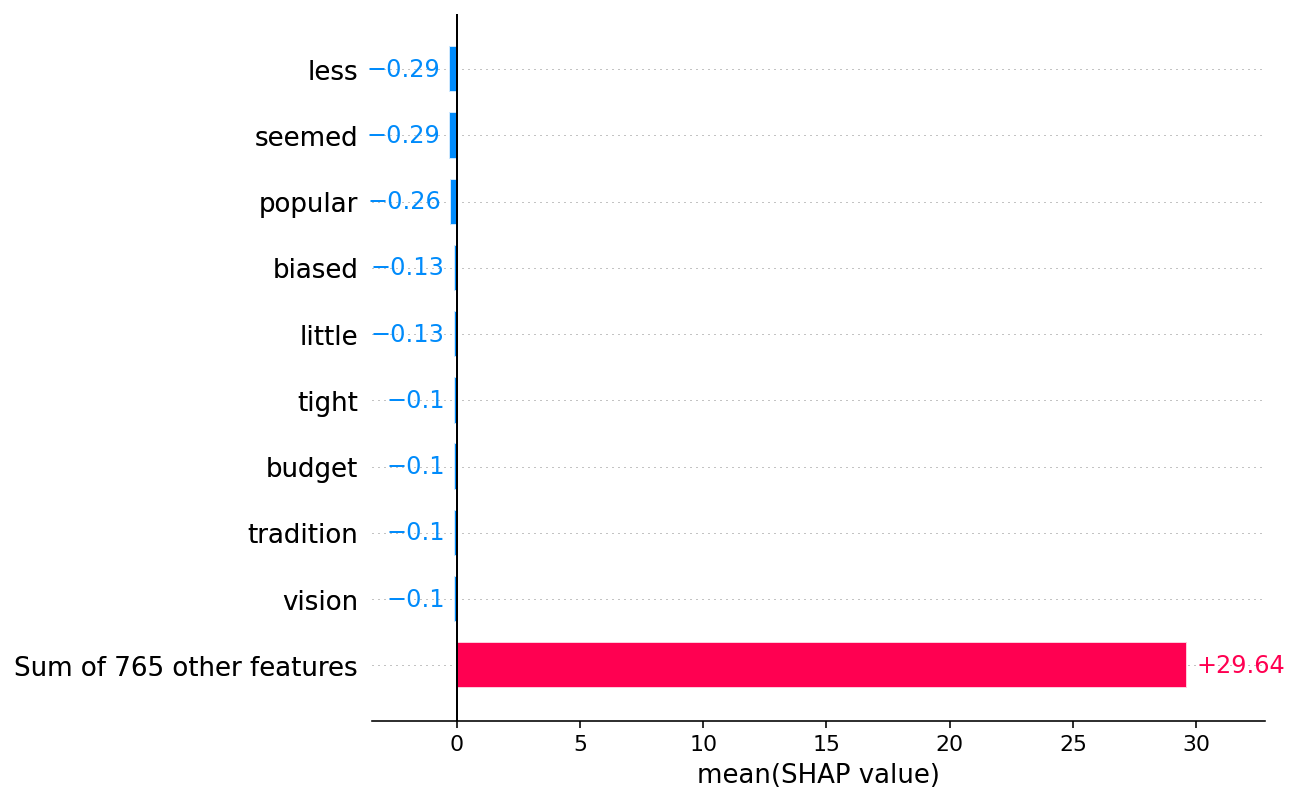

In [59]:
shap.plots.bar(shap_values[:, :, "POSITIVE"].mean(0), order=shap.Explanation.argsort)